In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pickle

%matplotlib inline

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
trng_data = pd.read_csv('training set values.csv')
trng_lbl = pd.read_csv('training set labels.csv')

In [3]:
# Convert status_group to numerical.
trng_lbl['status_group'] = trng_lbl.status_group.map({'functional':0, 'functional needs repair':1, 'non functional':2})

In [4]:
data = pd.merge(trng_data,trng_lbl,how ='outer',on ='id',)

In [5]:
data.columns

Index([u'id', u'amount_tsh', u'date_recorded', u'funder', u'gps_height',
       u'installer', u'longitude', u'latitude', u'wpt_name', u'num_private',
       u'basin', u'subvillage', u'region', u'region_code', u'district_code',
       u'lga', u'ward', u'population', u'public_meeting', u'recorded_by',
       u'scheme_management', u'scheme_name', u'permit', u'construction_year',
       u'extraction_type', u'extraction_type_group', u'extraction_type_class',
       u'management', u'management_group', u'payment', u'payment_type',
       u'water_quality', u'quality_group', u'quantity', u'quantity_group',
       u'source', u'source_type', u'source_class', u'waterpoint_type',
       u'waterpoint_type_group', u'status_group'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [7]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,2
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0


# Feature Transformation/Engineering

# Date Features: date_recorded, construction_year

In [8]:
# Convert dates from strings
data['date_recorded'] = pd.to_datetime(data['date_recorded'])
data['construction_year'] = pd.to_datetime(data['construction_year'])

In [9]:
data['age_of_pump_mnths'] = (data['date_recorded']-data['construction_year'])/np.timedelta64(1, 'Y')

In [10]:
data.drop('date_recorded',axis = 1, inplace = True)
data.drop('construction_year',axis =1, inplace = True)

# Geographical Features: longitude, latitude, gps_height,basin, subvillage, region, region_code,district_code,lga,ward.

In [11]:
geo_data = data[['longitude','latitude','gps_height','basin','subvillage',
                 'region','region_code','district_code','lga','ward']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010DC35C0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000BE4C860>]], dtype=object)

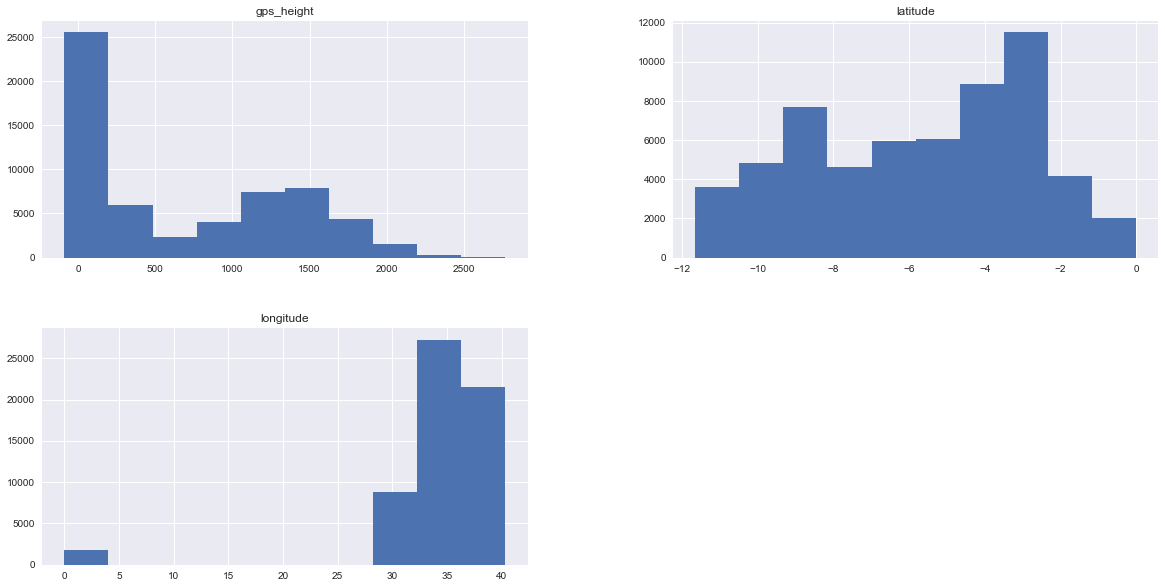

In [12]:
geo_data[['longitude','latitude','gps_height']].hist(figsize = (20,10))

In [13]:
geo_data.groupby(['region','region_code','district_code','basin','subvillage','lga','ward']).size()

region  region_code  district_code  basin        subvillage           lga      ward       
Arusha  2            1              Internal     Alasai               Monduli  Monduli Juu    1
                                                 Arkaria              Monduli  Sepeko         5
                                                 Baraka               Monduli  Esilalei       4
                                                 Bomba                Monduli  Selela         3
                                                 Chemchem             Monduli  Esilalei       1
                                                 Duka Bovu            Monduli  Sepeko         5
                                                 Dukambili            Monduli  Sepeko         2
                                                 Emogoro              Monduli  Sepeko         1
                                                 Emugurunanyoki       Monduli  Sepeko         1
                                             

In [14]:
for i in geo_data.columns:
    print i,len(geo_data[i].unique()),geo_data[i].unique()
    print ""

longitude 57516 [ 34.93809275  34.6987661   37.46066446 ...,  34.01708706  35.86131531
  38.10404822]

latitude 57517 [-9.85632177 -2.14746569 -3.82132853 ..., -8.75043433 -6.37857327
 -6.74746425]

gps_height 2428 [1390 1399  686 ...,  -90 2091 2366]

basin 9 ['Lake Nyasa' 'Lake Victoria' 'Pangani' 'Ruvuma / Southern Coast'
 'Internal' 'Lake Tanganyika' 'Wami / Ruvu' 'Rufiji' 'Lake Rukwa']

subvillage 19288 ['Mnyusi B' 'Nyamara' 'Majengo' ..., 'Itete B' 'Maore Kati' 'Kikatanyemba']

region 21 ['Iringa' 'Mara' 'Manyara' 'Mtwara' 'Kagera' 'Tanga' 'Shinyanga' 'Tabora'
 'Pwani' 'Ruvuma' 'Kilimanjaro' 'Rukwa' 'Mwanza' 'Kigoma' 'Lindi' 'Dodoma'
 'Arusha' 'Mbeya' 'Singida' 'Morogoro' 'Dar es Salaam']

region_code 27 [11 20 21 90 18  4 17 14 60 10  3 15 19 16 80  1  6  2 12 13  5  7 99 24  9
  8 40]

district_code 20 [ 5  2  4 63  1  8  3  6 43  7 23 33 53 62 60 30 13  0 80 67]

lga 125 ['Ludewa' 'Serengeti' 'Simanjiro' 'Nanyumbu' 'Karagwe' 'Mkinga'
 'Shinyanga Rural' 'Kahama' 'Tabora Urban' 

In [15]:
geo_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 10 columns):
longitude        59400 non-null float64
latitude         59400 non-null float64
gps_height       59400 non-null int64
basin            59400 non-null object
subvillage       59029 non-null object
region           59400 non-null object
region_code      59400 non-null int64
district_code    59400 non-null int64
lga              59400 non-null object
ward             59400 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 7.5+ MB


Looking at the data above, for initial attempt we will;
1. Impute Longitude,Latitude and GPS Height by mean
2. For remaining features will encode the values individually.

In [16]:
mean_imputation = ['longitude','latitude','gps_height']
label_encode = ['basin','subvillage','region','region_code','district_code','lga','ward']

In [17]:
def geo_feat_eng(df):
    le = LabelEncoder()
    for i in df.columns:
        print ""
        print "Picked up Feature: "+i
        if i in mean_imputation:
            df[i].replace(0, np.nan, inplace=True)
            df[i].fillna(df[i].mean(),inplace = True)
            print "Imputed mean for Feature: "+i
        elif i in label_encode:
            le.fit(df[i])
            print "Fitting LabelEncoder on Feature: "+i
            df[i] = le.transform(df[i])
            print "Transformed Feature: "+i
        else:
            print "Ignored, Out of scope"
    return df.dtypes

In [18]:
geo_feat_eng(data)


Picked up Feature: id
Ignored, Out of scope

Picked up Feature: amount_tsh
Ignored, Out of scope

Picked up Feature: funder
Ignored, Out of scope

Picked up Feature: gps_height
Imputed mean for Feature: gps_height

Picked up Feature: installer
Ignored, Out of scope

Picked up Feature: longitude
Imputed mean for Feature: longitude

Picked up Feature: latitude
Imputed mean for Feature: latitude

Picked up Feature: wpt_name
Ignored, Out of scope

Picked up Feature: num_private
Ignored, Out of scope

Picked up Feature: basin
Fitting LabelEncoder on Feature: basin

C:\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:216: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
C:\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:275: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]



Transformed Feature: basin

Picked up Feature: subvillage
Fitting LabelEncoder on Feature: subvillage
Transformed Feature: subvillage

Picked up Feature: region
Fitting LabelEncoder on Feature: region
Transformed Feature: region

Picked up Feature: region_code
Fitting LabelEncoder on Feature: region_code
Transformed Feature: region_code

Picked up Feature: district_code
Fitting LabelEncoder on Feature: district_code
Transformed Feature: district_code

Picked up Feature: lga
Fitting LabelEncoder on Feature: lga
Transformed Feature: lga

Picked up Feature: ward
Fitting LabelEncoder on Feature: ward
Transformed Feature: ward

Picked up Feature: population
Ignored, Out of scope

Picked up Feature: public_meeting
Ignored, Out of scope

Picked up Feature: recorded_by
Ignored, Out of scope

Picked up Feature: scheme_management
Ignored, Out of scope

Picked up Feature: scheme_name
Ignored, Out of scope

Picked up Feature: permit
Ignored, Out of scope

Picked up Feature: extraction_type
Ignore

id                         int64
amount_tsh               float64
funder                    object
gps_height               float64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                      int64
subvillage                 int64
region                     int64
region_code                int64
district_code              int64
lga                        int64
ward                       int64
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_quality             object
quality_gr

# Remaining Features:

In [19]:
other_feats = [(i) for i in data.columns if data[i].dtype not in ['int64','float64']]

In [20]:
remaining_feats = []

In [21]:
print len(other_feats), other_feats

24 ['funder', 'installer', 'wpt_name', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [22]:
# Lets check out features which seem to be repeating but the data might be at a different level.
def ret_grouped_view(cols):
    lcols = list(cols)
    return data.groupby(lcols).size()

In [23]:
# In scheme_names there were same strings but segregrated in diff groups due to caps, maybe should do this with
# everything before encoding.

#data['scheme_name'] = data['scheme_name'].str.lower()
ret_grouped_view(('scheme_management', 'scheme_name'))
#data['scheme_name'].value_counts()

# Tried to make sence of scheme names but it doesn't seem to have any logic, hence dropping name and adding
# to rem_feat list.

data.drop('scheme_name',axis = 1, inplace = True)
remaining_feats.append('scheme_management')

In [24]:
ret_grouped_view(('extraction_type', 'extraction_type_group','extraction_type_class'))

extraction_type            extraction_type_group  extraction_type_class
afridev                    afridev                handpump                  1770
cemo                       other motorpump        motorpump                   90
climax                     other motorpump        motorpump                   32
gravity                    gravity                gravity                  26780
india mark ii              india mark ii          handpump                  2400
india mark iii             india mark iii         handpump                    98
ksb                        submersible            submersible               1415
mono                       mono                   motorpump                 2865
nira/tanira                nira/tanira            handpump                  8154
other                      other                  other                     6430
other - mkulima/shinyanga  other handpump         handpump                     2
other - play pump          other hand

In [25]:
# Dropping ext type and using other two
data.drop('extraction_type_group',axis = 1,inplace = True)
remaining_feats.append('extraction_type')
remaining_feats.append('extraction_type_class')

In [26]:
ret_grouped_view(('management', 'management_group'))

management        management_group
company           commercial            685
other             other                 844
other - school    other                  99
parastatal        parastatal           1768
private operator  commercial           1971
trust             commercial             78
unknown           unknown               561
vwc               user-group          40507
water authority   commercial            904
water board       user-group           2933
wua               user-group           2535
wug               user-group           6515
dtype: int64

In [27]:
# Dropping mgmt grp
data.drop('management_group',axis = 1, inplace=True)
remaining_feats.append('management')

In [28]:
ret_grouped_view(('water_quality', 'quality_group'))

water_quality       quality_group
coloured            colored            490
fluoride            fluoride           200
fluoride abandoned  fluoride            17
milky               milky              804
salty               salty             4856
salty abandoned     salty              339
soft                good             50818
unknown             unknown           1876
dtype: int64

In [29]:
# Dropping quality_grp
data.drop('quality_group',axis = 1, inplace=True)
remaining_feats.append('water_quality')

In [30]:
ret_grouped_view(('quantity', 'quantity_group'))

quantity      quantity_group
dry           dry                6246
enough        enough            33186
insufficient  insufficient      15129
seasonal      seasonal           4050
unknown       unknown             789
dtype: int64

In [31]:
# Dropping quantity_group
data.drop('quantity_group',axis = 1, inplace=True)
remaining_feats.append('quantity')

In [32]:
ret_grouped_view(('source', 'source_type', 'source_class'))

source                source_type           source_class
dam                   dam                   surface           656
hand dtw              borehole              groundwater       874
lake                  river/lake            surface           765
machine dbh           borehole              groundwater     11075
other                 other                 unknown           212
rainwater harvesting  rainwater harvesting  surface          2295
river                 river/lake            surface          9612
shallow well          shallow well          groundwater     16824
spring                spring                groundwater     17021
unknown               other                 unknown            66
dtype: int64

In [33]:
#As source seems to be cleanest using source dropping other two.
data.drop('source',inplace=True,axis=1)
data.drop('source_type',inplace=True,axis=1)
remaining_feats.append('source_class')

In [34]:
ret_grouped_view(('waterpoint_type', 'waterpoint_type_group'))

waterpoint_type              waterpoint_type_group
cattle trough                cattle trough              116
communal standpipe           communal standpipe       28522
communal standpipe multiple  communal standpipe        6103
dam                          dam                          7
hand pump                    hand pump                17488
improved spring              improved spring            784
other                        other                     6380
dtype: int64

In [35]:
data.drop('waterpoint_type_group',inplace=True,axis=1)
remaining_feats.append('waterpoint_type')

In [36]:
ret_grouped_view(('payment','payment_type'))

payment                payment_type
never pay              never pay       25348
other                  other            1054
pay annually           annually         3642
pay monthly            monthly          8300
pay per bucket         per bucket       8985
pay when scheme fails  on failure       3914
unknown                unknown          8157
dtype: int64

In [37]:
data.drop('payment',inplace=True,axis=1)
remaining_feats.append('payment_type')

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 31 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
funder                   55765 non-null object
gps_height               59400 non-null float64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null int64
subvillage               59400 non-null int64
region                   59400 non-null int64
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null int64
ward                     59400 non-null int64
population               59400 non-null int64
public_meeting           56066 non-null object
recorded_by              59400 non-null object
sche

In [39]:
# There were non repeating objects which we need to account for:
for i in data.columns:
    if data[i].dtype not in ['int64','float64']:
        if i not in remaining_feats:
            print i

funder
installer
wpt_name
public_meeting
recorded_by
permit


In [40]:
#Also dropping pub meeting, rec by
data.drop('public_meeting',inplace=True,axis=1)
data.drop('recorded_by',inplace=True,axis=1)

remaining_feats.append('funder')
remaining_feats.append('installer')
remaining_feats.append('wpt_name')

In [41]:
remaining_feats

['scheme_management',
 'extraction_type',
 'extraction_type_class',
 'management',
 'water_quality',
 'quantity',
 'source_class',
 'waterpoint_type',
 'payment_type',
 'funder',
 'installer',
 'wpt_name']

In [42]:
for i in remaining_feats:
    print i, data[i].dtypes

scheme_management object
extraction_type object
extraction_type_class object
management object
water_quality object
quantity object
source_class object
waterpoint_type object
payment_type object
funder object
installer object
wpt_name object


In [43]:
def feat_eng(df):
    le = LabelEncoder()
    for i in df.columns:
        print ""
        print "Picked up Feature: "+i
        if i in remaining_feats:
            df[i] = df[i].str.lower()
            le.fit(df[i])
            print "Fitting LabelEncoder on Feature: "+i
            df[i] = le.transform(df[i])
            print "Transformed Feature: "+i
        else:
            print "Ignored, Out of scope"
    return df.dtypes

In [44]:
feat_eng(data)


Picked up Feature: id
Ignored, Out of scope

Picked up Feature: amount_tsh
Ignored, Out of scope

Picked up Feature: funder
Fitting LabelEncoder on Feature: funder
Transformed Feature: funder

Picked up Feature: gps_height
Ignored, Out of scope

Picked up Feature: installer
Fitting LabelEncoder on Feature: installer
Transformed Feature: installer

Picked up Feature: longitude
Ignored, Out of scope

Picked up Feature: latitude
Ignored, Out of scope

Picked up Feature: wpt_name
Fitting LabelEncoder on Feature: wpt_name
Transformed Feature: wpt_name

Picked up Feature: num_private
Ignored, Out of scope

Picked up Feature: basin
Ignored, Out of scope

Picked up Feature: subvillage
Ignored, Out of scope

Picked up Feature: region
Ignored, Out of scope

Picked up Feature: region_code
Ignored, Out of scope

Picked up Feature: district_code
Ignored, Out of scope

Picked up Feature: lga
Ignored, Out of scope

Picked up Feature: ward
Ignored, Out of scope

Picked up Feature: population
Ignored,

id                         int64
amount_tsh               float64
funder                     int64
gps_height               float64
installer                  int64
longitude                float64
latitude                 float64
wpt_name                   int64
num_private                int64
basin                      int64
subvillage                 int64
region                     int64
region_code                int64
district_code              int64
lga                        int64
ward                       int64
population                 int64
scheme_management          int64
permit                    object
extraction_type            int64
extraction_type_class      int64
management                 int64
payment_type               int64
water_quality              int64
quantity                   int64
source_class               int64
waterpoint_type            int64
status_group               int64
age_of_pump_mnths        float64
dtype: object

In [45]:
data.dtypes

id                         int64
amount_tsh               float64
funder                     int64
gps_height               float64
installer                  int64
longitude                float64
latitude                 float64
wpt_name                   int64
num_private                int64
basin                      int64
subvillage                 int64
region                     int64
region_code                int64
district_code              int64
lga                        int64
ward                       int64
population                 int64
scheme_management          int64
permit                    object
extraction_type            int64
extraction_type_class      int64
management                 int64
payment_type               int64
water_quality              int64
quantity                   int64
source_class               int64
waterpoint_type            int64
status_group               int64
age_of_pump_mnths        float64
dtype: object

In [46]:
# Handle the last obj
data['permit'].fillna(False,inplace = True)
data['permit'] = data.permit.map({True:0, False:1})

In [47]:
len(data.columns)

29

Creating a new DF so that all prev changes to data remains intact.

In [48]:
cleaned_data = pd.DataFrame(data)

In [49]:
cleaned_data.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,extraction_type,extraction_type_class,management,payment_type,water_quality,quantity,source_class,waterpoint_type,status_group,age_of_pump_mnths
0,69572,6000.0,1370,1390.000000,1411,34.938093,-9.856322,32436,0,1,...,3,0,7,0,6,1,0,1,0,41.197287
1,8776,0.0,470,1399.000000,532,34.698766,-2.147466,37195,0,4,...,3,0,11,2,6,2,1,1,0,43.176794
2,34310,25.0,826,686.000000,1906,37.460664,-3.821329,14572,0,5,...,3,0,7,5,6,1,1,2,0,43.152152
3,67743,0.0,1742,263.000000,1754,38.486161,-11.155298,37285,0,7,...,14,5,7,2,6,0,0,2,2,43.075491
4,19728,0.0,21,1018.860839,105,31.130847,-1.825359,35529,0,4,...,3,0,1,2,6,3,1,1,0,41.528573


In [50]:
cleaned_data.drop('id',axis=1,inplace=True)

In [51]:
features = cleaned_data.drop('status_group',axis = 1)

In [52]:
features.to_csv('training_cleaned_data_unscaled',index = False)

In [53]:
sc = StandardScaler()
sc.fit(features)
std_features = sc.fit_transform(features)
std_features = pd.DataFrame(std_features,columns = features.columns)
std_features.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,permit,extraction_type,extraction_type_class,management,payment_type,water_quality,quantity,source_class,waterpoint_type,age_of_pump_mnths
0,1.895665,0.989218,7.481040e-01,1.383975,-0.082411,-1.408791,0.997360,-0.038749,-1.244276,0.401718,...,1.375061,-0.790543,-0.777459,-0.134813,-1.547906,0.272762,-0.405301,-0.538410,-0.883614,-1.141136
1,-0.105970,-0.531750,7.662453e-01,-0.231291,-0.175631,1.207934,1.405436,-0.038749,-0.031205,1.131148,...,-0.727241,-0.790543,-0.777459,1.820837,-0.458639,0.272762,0.838878,1.765074,-0.883614,1.022152
2,-0.097630,0.069877,-6.709466e-01,2.293596,0.900156,0.639751,-0.534447,-0.038749,0.373152,-0.092833,...,-0.727241,-0.790543,-0.777459,-0.134813,1.175263,0.272762,-0.405301,1.765074,-0.322265,0.995223
3,-0.105970,1.617885,-1.523586e+00,2.014278,1.299597,-1.849720,1.413154,-0.038749,1.181867,-0.109480,...,-0.727241,1.819858,2.296319,-0.134813,-0.458639,0.272762,-1.649479,-0.538410,-0.322265,0.911444
4,-0.105970,-1.290545,-2.291582e-16,-1.015954,-1.565372,1.317271,1.262580,-0.038749,-0.031205,-0.341827,...,-0.727241,-0.790543,-0.777459,-3.068289,-0.458639,0.272762,2.083056,1.765074,-0.883614,-0.779092


In [54]:
std_features.to_csv('training_cleaned_data',index = False)

# Start from here next time instead of going through the whole cleaning process!

In [55]:
X = pd.read_csv('training_cleaned_data')
y = data['status_group']

In [56]:
X.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,permit,extraction_type,extraction_type_class,management,payment_type,water_quality,quantity,source_class,waterpoint_type,age_of_pump_mnths
0,1.895665,0.989218,7.481040e-01,1.383975,-0.082411,-1.408791,0.997360,-0.038749,-1.244276,0.401718,...,1.375061,-0.790543,-0.777459,-0.134813,-1.547906,0.272762,-0.405301,-0.538410,-0.883614,-1.141136
1,-0.105970,-0.531750,7.662453e-01,-0.231291,-0.175631,1.207934,1.405436,-0.038749,-0.031205,1.131148,...,-0.727241,-0.790543,-0.777459,1.820837,-0.458639,0.272762,0.838878,1.765074,-0.883614,1.022152
2,-0.097630,0.069877,-6.709466e-01,2.293596,0.900156,0.639751,-0.534447,-0.038749,0.373152,-0.092833,...,-0.727241,-0.790543,-0.777459,-0.134813,1.175263,0.272762,-0.405301,1.765074,-0.322265,0.995223
3,-0.105970,1.617885,-1.523586e+00,2.014278,1.299597,-1.849720,1.413154,-0.038749,1.181867,-0.109480,...,-0.727241,1.819858,2.296319,-0.134813,-0.458639,0.272762,-1.649479,-0.538410,-0.322265,0.911444
4,-0.105970,-1.290545,-2.291582e-16,-1.015954,-1.565372,1.317271,1.262580,-0.038749,-0.031205,-0.341827,...,-0.727241,-0.790543,-0.777459,-3.068289,-0.458639,0.272762,2.083056,1.765074,-0.883614,-0.779092


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print "Data: ", data.shape
print "X_Train: ", X_train.shape
print "X_Test: ", X_test.shape
print "y_Train: ", y_train.shape
print "y_Test: : ", y_test.shape

Data:  (59400, 29)
X_Train:  (41580, 27)
X_Test:  (17820, 27)
y_Train:  (41580,)
y_Test: :  (17820,)


# RandomForestClassifier

In [58]:
rc  = RandomForestClassifier(n_estimators=100,max_depth=20,max_features='sqrt')
rcp = rc.fit(X_train,y_train)

In [59]:
pred = rcp.predict(X_test)

print(classification_report(y_test,pred))

In [61]:
print(confusion_matrix(y_test,pred))

[[8822  149  756]
 [ 697  385  201]
 [1523   72 5215]]


/Users/rakesh/Library/Python/2.7/lib/python/site-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [62]:
print(accuracy_score(y_test, pred))

0.809315375982


In [63]:
# Save the model
rcp_out = open('RFC.pickle','wb')
pickle.dump(rcp,rcp_out)
rcp_out.close()

# Train the same model on non-scaled data.

In [64]:
X = pd.read_csv('training_cleaned_data_unscaled')
y = data['status_group']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print "Data: ", data.shape
print "X_Train: ", X_train.shape
print "X_Test: ", X_test.shape
print "y_Train: ", y_train.shape
print "y_Test: : ", y_test.shape

Data:  (59400, 29)
X_Train:  (41580, 27)
X_Test:  (17820, 27)
y_Train:  (41580,)
y_Test: :  (17820,)


In [66]:
rc_ns  = RandomForestClassifier(n_estimators=100,max_depth=20,max_features='sqrt')
rcp_ns = rc_ns.fit(X_train,y_train)

In [67]:
pred = rcp_ns.predict(X_test)

In [68]:
print(classification_report(y_test,pred))
print ""
print ""
print(confusion_matrix(y_test,pred))
print ""
print ""
print(accuracy_score(y_test, pred))

             precision    recall  f1-score   support

          0       0.79      0.91      0.85      9619
          1       0.65      0.29      0.40      1343
          2       0.85      0.77      0.81      6858

avg / total       0.80      0.81      0.80     17820



[[8709  148  762]
 [ 762  391  190]
 [1505   62 5291]]


0.807575757576


# PCA on NonScaled Data

In [69]:
d = pd.read_csv('training_cleaned_data_unscaled')

In [71]:
from sklearn.decomposition import PCA

In [78]:
pca = PCA()

In [79]:
x = pca.fit_transform(d)

In [80]:
std_features_pca = pd.DataFrame(x,columns = features.columns)
std_features_pca.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,permit,extraction_type,extraction_type_class,management,payment_type,water_quality,quantity,source_class,waterpoint_type,age_of_pump_mnths
0,-11757.181488,1534.394654,5656.546751,950.832287,254.241385,-310.862756,-1.576760,-211.571338,12.833634,-0.932875,...,-0.542616,-1.189588,-2.100062,-0.455121,0.218051,-0.099303,0.438189,0.699179,0.668088,-0.187141
1,-16728.481646,5280.324885,-360.530502,-256.844818,484.831239,-350.493930,245.065999,-132.121484,-39.861597,-0.599739,...,0.755779,2.229170,-1.579405,-5.344751,0.402489,-0.318447,-0.444557,-0.107593,-0.082924,0.556054
2,6251.633372,-143.210227,-276.925502,882.431691,520.427604,396.229570,-131.815271,-888.680822,-37.464077,-1.511606,...,3.843635,0.322213,-1.106991,-0.136393,-1.364129,0.034409,0.576624,0.454234,-0.393043,0.692946
3,-16416.714335,-1571.591604,-358.312344,1401.981153,443.239992,680.035957,-531.229952,-144.519617,-28.172383,-1.900175,...,-0.682356,-2.509931,0.317951,-1.158690,1.204244,-0.758777,0.347064,-1.945892,-0.084001,-0.317193
4,-14585.867868,-2743.672752,-354.624798,-916.916076,708.033422,-139.837455,-139.521126,-94.973447,35.685842,-0.831204,...,-0.875689,-2.071895,2.063845,-0.339846,-0.693959,0.315981,-1.043422,0.668550,-0.179312,0.275715


In [81]:
X = std_features_pca
y = data['status_group']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print "Data: ", data.shape
print "X_Train: ", X_train.shape
print "X_Test: ", X_test.shape
print "y_Train: ", y_train.shape
print "y_Test: : ", y_test.shape

Data:  (59400, 29)
X_Train:  (41580, 27)
X_Test:  (17820, 27)
y_Train:  (41580,)
y_Test: :  (17820,)


In [83]:
rc_pca  = RandomForestClassifier(n_estimators=100,max_depth=20,max_features='sqrt')
rcp_pca = rc_pca.fit(X_train,y_train)

In [84]:
pca_pred = rcp_pca.predict(X_test)

In [85]:
print(classification_report(y_test,pca_pred))
print ""
print ""
print(confusion_matrix(y_test,pca_pred))
print ""
print ""
print(accuracy_score(y_test, pca_pred))

             precision    recall  f1-score   support

          0       0.77      0.89      0.83      9659
          1       0.62      0.24      0.34      1356
          2       0.81      0.73      0.77      6805

avg / total       0.78      0.78      0.77     17820



[[8636  130  893]
 [ 795  321  240]
 [1766   66 4973]]


0.781705948373


#  KNeighborsClassifier

In [63]:
knn_c  = KNeighborsClassifier(n_neighbors=15)

In [64]:
knn = knn_c.fit(X_train,y_train)

In [65]:
n_pred = knn.predict(X_test)

In [66]:
print(confusion_matrix(y_test,n_pred))

[[8399  146 1138]
 [ 741  254  271]
 [2428  120 4323]]


In [67]:
print(classification_report(y_test,n_pred))

             precision    recall  f1-score   support

          0       0.73      0.87      0.79      9683
          1       0.49      0.20      0.28      1266
          2       0.75      0.63      0.69      6871

avg / total       0.72      0.73      0.71     17820



In [68]:
print(accuracy_score(y_test,n_pred))

0.728170594837


In [69]:
# Save the model
rcp_out = open('KNN.pickle','wb')
pickle.dump(knn,rcp_out)
rcp_out.close()

# LinearSVC

In [70]:
from sklearn.svm import LinearSVC

In [71]:
lsvc_classifier = LinearSVC(random_state=0)

In [72]:
lsvc = lsvc_classifier.fit(X_train,y_train)

In [73]:
l_pred = lsvc.predict(X_test)

In [74]:
print(confusion_matrix(y_test,l_pred))

[[7901    0 1782]
 [1047    0  219]
 [3733    0 3138]]


In [75]:
print(classification_report(y_test,l_pred))

             precision    recall  f1-score   support

          0       0.62      0.82      0.71      9683
          1       0.00      0.00      0.00      1266
          2       0.61      0.46      0.52      6871

avg / total       0.57      0.62      0.59     17820



/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [76]:
print(accuracy_score(y_test,l_pred))

0.619472502806


In [77]:
# Save the model
rcp_out = open('LSVC.pickle','wb')
pickle.dump(lsvc,rcp_out)
rcp_out.close()

# Logistic Regression

In [78]:
lr_classifier = LogisticRegression(solver ='newton-cg',multi_class='ovr')

In [79]:
lr = lr_classifier.fit(X_train,y_train)

In [80]:
lr_pred = lr.predict(X_test)

In [81]:
print(confusion_matrix(y_test,lr_pred))

[[7855    0 1828]
 [1051    0  215]
 [3703    0 3168]]


In [82]:
print(classification_report(y_test,lr_pred))

             precision    recall  f1-score   support

          0       0.62      0.81      0.70      9683
          1       0.00      0.00      0.00      1266
          2       0.61      0.46      0.52      6871

avg / total       0.57      0.62      0.59     17820



In [83]:
print(accuracy_score(y_test,lr_pred))

0.618574635241


# BernoulliNB

In [84]:
from sklearn.naive_bayes import BernoulliNB

In [85]:
brn_class = BernoulliNB()

In [86]:
brn = brn_class.fit(X_train,y_train)

In [87]:
brn_pred = brn.predict(X_test)

In [88]:
print(confusion_matrix(y_test,brn_pred))
print ""
print ""
print(classification_report(y_test,brn_pred))
print ""
print ""
print(accuracy_score(y_test,brn_pred))

[[6768  117 2798]
 [ 850   69  347]
 [3077   81 3713]]


             precision    recall  f1-score   support

          0       0.63      0.70      0.66      9683
          1       0.26      0.05      0.09      1266
          2       0.54      0.54      0.54      6871

avg / total       0.57      0.59      0.58     17820



0.592031425365


# DecisionTreeClassifier

In [89]:
from sklearn.tree import DecisionTreeClassifier

In [90]:
dtc_class = DecisionTreeClassifier()

In [91]:
dtc = dtc_class.fit(X_train,y_train)

In [92]:
dtc_pred = dtc.predict(X_test)

In [93]:
print(confusion_matrix(y_test,dtc_pred))
print ""
print ""
print(classification_report(y_test,dtc_pred))
print ""
print ""
print(accuracy_score(y_test,dtc_pred))

[[7564  655 1464]
 [ 573  461  232]
 [1391  281 5199]]


             precision    recall  f1-score   support

          0       0.79      0.78      0.79      9683
          1       0.33      0.36      0.35      1266
          2       0.75      0.76      0.76      6871

avg / total       0.75      0.74      0.74     17820



0.742087542088


# MLPClassifier

In [94]:
from sklearn.neural_network import MLPClassifier

In [95]:
mlp_class = MLPClassifier(hidden_layer_sizes=(100,10))

In [96]:
mlp = mlp_class.fit(X_train,y_train)

In [97]:
mlp_pred = mlp.predict(X_test)

In [98]:
print(confusion_matrix(y_test,mlp_pred))
print ""
print ""
print(classification_report(y_test,mlp_pred))
print ""
print ""
print(accuracy_score(y_test,mlp_pred))

[[8371  175 1137]
 [ 721  267  278]
 [1865   89 4917]]


             precision    recall  f1-score   support

          0       0.76      0.86      0.81      9683
          1       0.50      0.21      0.30      1266
          2       0.78      0.72      0.74      6871

avg / total       0.75      0.76      0.75     17820



0.760662177329
